In [1]:
import sys, pathlib
sys.path.insert(0, str(pathlib.Path.cwd().parent.parent))  # add repo root
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import cmcrameri.cm as cm

## Load data
Marginal probabilities from "data/sys_probs.json"\
Conditional (upon loss of 1 component) from "data/cond_sys_probs.json"

In [2]:
DATASET = Path("data") 

# Marginal system probabilities
sys_probs = pd.read_json(DATASET / "sys_probs.json")
print("Marginal system probabilities loaded.")

# Conditional system probabilities
cond_sys_probs = pd.read_json(DATASET / "cond_sys_probs.json")
print("Conditional system probabilities loaded.")

Marginal system probabilities loaded.
Conditional system probabilities loaded.


## Compute robustness index
Robustness index for the system given the loss of one component for the system states:
* System failure
* Partial failure
* Survival

In [3]:
# Load component names
component_names = cond_sys_probs["Component"].tolist()

# Load marginals conditional upon no damage
p_0f = np.array(sys_probs["System failure"])
p_0p = np.array(sys_probs["Partial failure"])
p_0s = np.array(sys_probs["Survival"])

# Load marginals conditional upon the loss of one component
p_1f = np.array(cond_sys_probs["System failure"])
p_1p = np.array(cond_sys_probs["Partial failure"])
p_1s = np.array(cond_sys_probs["Survival"])

# Calculate robustness
Irob_multi = (p_0f/p_1f)**(-p_0f) * (p_0p/p_1p)**(-p_0p) * (p_0s/p_1s)**(-p_0s)
Irob_binary = ((1-p_0f)/(1-p_1f))**(-(1-p_0f)) * (p_0f/p_1f)**(-p_0f)
print("Robustness indices calculated.")

# Compute pi for system failure
pi_f = -norm.ppf(p_1f)

# Compute pi for partial failure
pi_p = -norm.ppf(p_1p)

# Store robustness indices in a DataFrame
df_Irob = pd.DataFrame({
    "Component": component_names,
    "Robustness index, multi-state": Irob_multi,
    "Robustness index, binary": Irob_binary,
    "P(System failure | No damage)": np.repeat(p_0f,len(component_names)),
    "P(Partial failure | No damage)": np.repeat(p_0p,len(component_names)),
    "P(System survival | No damage)": np.repeat(p_0s,len(component_names)),
    "P(System failure | 1 component lost)": p_1f,
    "P(Partial failure | 1 component lost)": p_1p,
    "P(System survival | 1 component lost)": p_1s,
    "pi(system failure)": pi_f,
    "pi(partial failure)": pi_p
})

# Save to a JSON file
df_Irob.to_json("data/robustness_indices.json", orient="records", indent=4)

Robustness indices calculated.


## Plot robustness indices

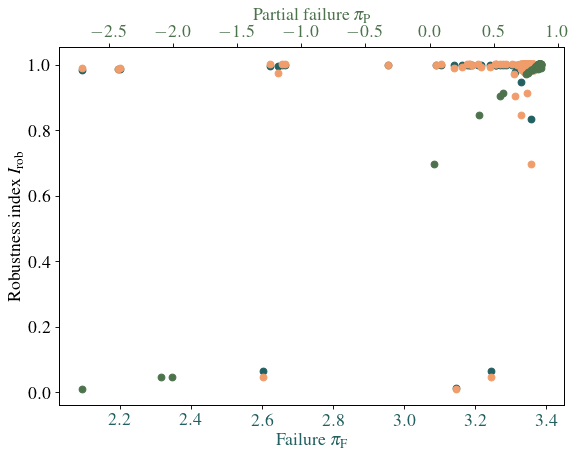

In [5]:
# Plot settings
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 16
plt.rc('font', family='times')

# Create plot
fig, ax1 = plt.subplots(figsize=plt.figaspect(0.8)*1.25,dpi=80)

ax1.set_ylabel(r'Robustness index $I_{\mathrm{rob}}$')

# Set axis 1 label
ax1.set_xlabel(r'Failure $\pi_{\mathrm{F}}$', color=cm.batlowS(3))
ax1.tick_params(axis='x', labelcolor=cm.batlowS(3))

# Plot data with label
ax1.plot(pi_f, Irob_multi, 'o', label='System failure', color=cm.batlowS(3))
ax1.plot(pi_f, Irob_binary, 'o', label='System failure', color=cm.batlowS(4))

# Create second axis
ax2 = ax1.twiny()

# Set axis 2 label
ax2.set_xlabel(r'Partial failure $\pi_{\mathrm{P}}$', color=cm.batlowS(5))
ax2.tick_params(axis='x', labelcolor=cm.batlowS(5))

# Plot data with label
ax2.plot(pi_p, Irob_binary, 'o', label='Partial failure', color=cm.batlowS(5))

# Set layout
plt.tight_layout()

# Save figure
plt.savefig(DATASET / "robustness_indices.pdf", dpi=300)

# Show and save the figure
plt.show()